## Tutorial - Seq2Seq With Pretrained Embeddings

We will learn how to improve the Seq2Seq model for NMT in Week 10 with pretrained embeddings.


We will use the same dataset and Seq2Seq model with attention from Week 10. Let's start loading data and defining Seq2Seq model.

In [1]:
!pip3 install torch==1.11.0 numpy matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.15.1 requires torch==2.0.0, but you have torch 1.11.0 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.11.0 which is incompatible.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but you have torch 1.11.0 which is incompatible.


In [2]:
## Requirements
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from google.colab import drive
drive.mount('/content/drive')
#replace the following path according to your Google Drive path
#%cd/gdrive/My Drive/Monash-FIT-S1-2022/Basic-CYK-Parser
folder_path = "/content/drive/MyDrive/Monash-FIT-S1-2023/week9"

Mounted at /content/drive


#### Loading data files

In [5]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [6]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split lines into pairs. The files are all English → Other Language, so if we want to translate from Other Language → English I added the `reverse` flag to reverse the pairs.

In [10]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(folder_path + '/data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


Since there are a lot of example sentences and we want to train something quickly, we’ll trim the data set to only relatively short and simple sentences. Here the maximum length is 10 words (that includes ending punctuation) and we’re filtering to sentences that translate to the form “I am” or “He is” etc. (accounting for apostrophes replaced earlier).

In [8]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

- Read text file and split into lines, split lines into pairs
- Normalize text, filter by length and content
- Make word lists from sentences in pairs


In [11]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je suis desole mais vous devez partir .', 'i m sorry but you need to leave .']


#### Pretrained Embeddings
NMT is notorious for data hungry. Our toy dataset only has less than thousand training sentence pairs which is quite small. While parallel data may be expensive to obtain, monolingual data is abundant and often cheap (even free) to grab from Wikipedia, books, news. With monolingual data, we can train a language model and embedding and then initialize our NMT model with the pretrained embedding, or even the encoder and decoder weight to improve performance of NMT model.

In this tutorial, we will use English and French pretrained embedding from [MUSE project](https://github.com/facebookresearch/MUSE).

In [12]:
!wget -nc https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.en.vec
!wget -nc https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.fr.vec

--2023-04-27 12:04:54--  https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.en.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.8.35, 13.35.8.51, 13.35.8.29, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.8.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 628614720 (599M) [text/plain]
Saving to: ‘wiki.multi.en.vec’

wiki.multi.en.vec   100%[===================>] 599.49M  23.8MB/s    in 27s     

2023-04-27 12:05:22 (22.2 MB/s) - ‘wiki.multi.en.vec’ saved [628614720/628614720]

--2023-04-27 12:05:22--  https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.fr.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.8.35, 13.35.8.51, 13.35.8.29, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.8.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 628737710 (600M) [text/plain]
Saving to: ‘wiki.multi.fr.vec’

wiki.multi.fr.vec   100%[===========

The English dictionary contains 20000 words and the embedding size is 300.
Our English vocab size is much smaller, similarly for our French vocabulary.

In [13]:
print(input_lang.name, input_lang.n_words)
print(output_lang.name, output_lang.n_words)

fra 4345
eng 2803


Hence, we only need to load the embeddings of words appeared in our English and French vocabularies.

In [14]:
embedding_dim = 300
def load_embeddings(embedding_file, vocab_lang):
  embeddings = np.zeros((vocab_lang.n_words, embedding_dim))
  with open(embedding_file, encoding='utf-8', newline='\n', errors='ignore') as f:
    for line in f:
        word, vect = line.rstrip().split(' ', 1)
        vect = np.fromstring(vect, sep=' ')
        if word in vocab_lang.word2index:
          embeddings[vocab_lang.word2index[word]] = vect
  embeddings = torch.from_numpy(embeddings).float()
  return embeddings

In [15]:
french_embedding = load_embeddings('wiki.multi.fr.vec', input_lang)
english_embedding = load_embeddings('wiki.multi.en.vec', output_lang)

In [16]:
english_embedding.shape

torch.Size([2803, 300])

#### Seq2Seq Model With Attention
In Week10 tutorial, we set the embedding size with the same hidden size of the RNN for simplicity. Since we use MUSE pretrained embedding here, we have to set the embedding size to 300 - the dimension of MUSE embedding. We will modify the EncoderRNN and AttnDecoderRNN to allow embedding size having different value to the RNN hidden size.

In [17]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, pretrained_embeddings=None):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        
        # load pretrained embedding if any
        if pretrained_embeddings is not None:
          self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        else:
          self.embedding = nn.Embedding(input_size, embedding_size)

        self.gru = nn.GRU(embedding_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [18]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH, pretrained_embeddings=None):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        # load pretrained embedding if any
        if pretrained_embeddings is not None:
          self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        else:
          self.embedding = nn.Embedding(self.output_size, self.embedding_size)

        self.attn = nn.Linear(self.hidden_size + self.embedding_size, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size + self.embedding_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


#### Preparing Training data
To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [19]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

#### Training Loop


In [20]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.

In [21]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

- Start a timer
- Initialize optimizers and criterion
- Create set of training pairs
- Start empty losses array for plotting

Then we call `train` many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss.



In [22]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)



#### Plotting results
Plotting is done with matplotlib, using the array of loss values `plot_losses` saved while training.

In [23]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline
    
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


#### Evaluation
Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.

In [24]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [25]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attention= evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

#### Training and Evaluating
With all these helper functions in place (it looks like extra work, but it makes it easier to run multiple experiments) we can actually initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small dataset we can use relatively small networks of 256 hidden nodes and a single GRU layer. After about 40 minutes on a MacBook CPU we’ll get some reasonable results.

In [26]:
hidden_size = 256
embedding_size = 300
encoder = EncoderRNN(input_lang.n_words, embedding_size, hidden_size, pretrained_embeddings=french_embedding).to(device)
decoder = AttnDecoderRNN(embedding_size, hidden_size, output_lang.n_words, dropout_p=0.1, pretrained_embeddings=english_embedding).to(device)


2m 13s (- 86m 30s) (5000 2%) 3.3265
4m 0s (- 76m 4s) (10000 5%) 2.7641
5m 50s (- 71m 56s) (15000 7%) 2.6103
7m 43s (- 69m 27s) (20000 10%) 2.5056
9m 35s (- 67m 8s) (25000 12%) 2.3741
11m 26s (- 64m 49s) (30000 15%) 2.2859
13m 17s (- 62m 41s) (35000 17%) 2.1516
15m 8s (- 60m 34s) (40000 20%) 2.0691
16m 59s (- 58m 30s) (45000 22%) 2.0025
18m 49s (- 56m 28s) (50000 25%) 1.9284
20m 42s (- 54m 34s) (55000 27%) 1.8649
22m 32s (- 52m 35s) (60000 30%) 1.7732
24m 22s (- 50m 37s) (65000 32%) 1.6925
26m 12s (- 48m 40s) (70000 35%) 1.6220
28m 0s (- 46m 41s) (75000 37%) 1.5656
29m 52s (- 44m 49s) (80000 40%) 1.5034
31m 47s (- 43m 0s) (85000 42%) 1.4551
33m 38s (- 41m 7s) (90000 45%) 1.3840
35m 31s (- 39m 16s) (95000 47%) 1.3167
37m 24s (- 37m 24s) (100000 50%) 1.2952
39m 16s (- 35m 32s) (105000 52%) 1.2548
41m 10s (- 33m 41s) (110000 55%) 1.1776
43m 3s (- 31m 49s) (115000 57%) 1.1205
44m 58s (- 29m 59s) (120000 60%) 1.0838
46m 50s (- 28m 6s) (125000 62%) 1.0494
48m 42s (- 26m 13s) (130000 65%) 1.04

<Figure size 432x288 with 0 Axes>

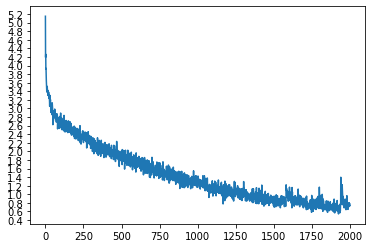

In [ ]:
trainIters(encoder, decoder, 200000, print_every=5000)

In [ ]:
evaluateRandomly(encoder, decoder)

> vous etes fort courageuse .
= you re very brave .
< you re very brave . <EOS>

> il est photographe professionnel .
= he s a professional photographer .
< he s a teacher photographer . <EOS>

> vous etes tres intelligentes .
= you re very intelligent .
< you re very timid . <EOS>

> nous sommes en train de le reparer .
= we re fixing it .
< we re fixing it . <EOS>

> elle porte un chapeau sympa .
= she s wearing a cool hat .
< she s wearing a cool hat . <EOS>

> c est un pauvre type sans c ur .
= he s a cold hearted jerk .
< he s a cold hearted . <EOS>

> je ne suis pas encore prete .
= i am not ready yet .
< i m still ready yet . <EOS>

> je ne suis pas medecin mais enseignant .
= i m not a doctor but a teacher .
< i m not a doctor but an teacher . <EOS>

> nous sommes prets desormais .
= we re ready now .
< we re ready now . <EOS>

> nous sommes toutes dingues .
= we re all crazy .
< we re all insane . <EOS>

